In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
from sklearn.manifold import TSNE
import seaborn as sns


c:\Users\kutay\miniconda3\envs\deepl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Resize((32, 32))
                                 ])
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

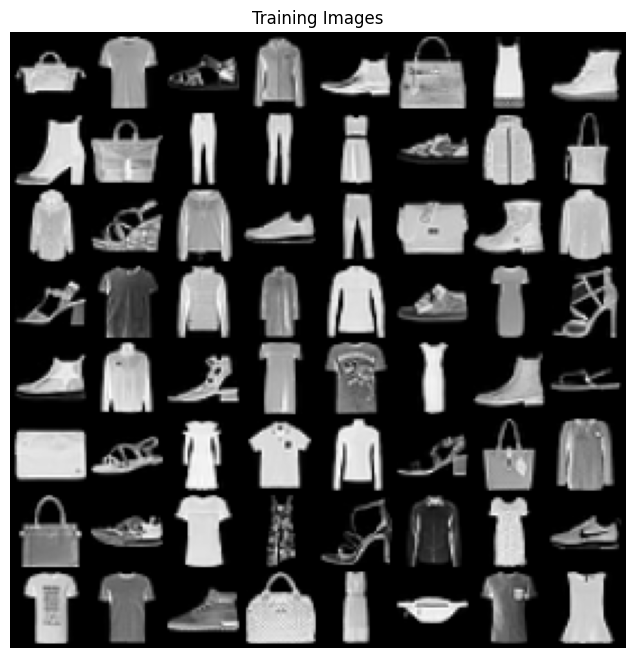

In [4]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

Epoch: 0, Step: 400, D Loss: 1.182479977607727, G Loss: 0.8710086941719055


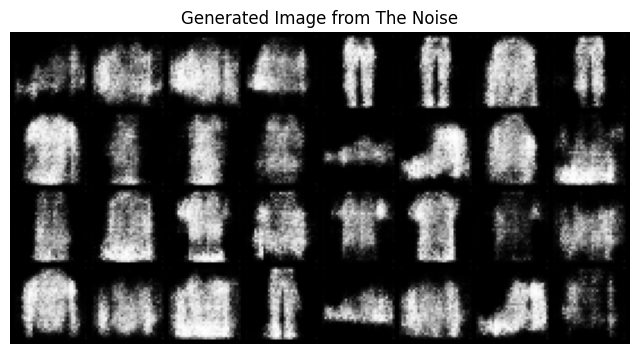

Epoch: 1, Step: 400, D Loss: 1.3314729928970337, G Loss: 1.386579990386963


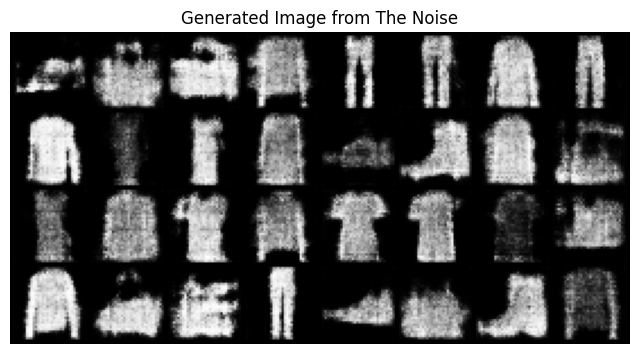

Epoch: 2, Step: 400, D Loss: 1.3678386211395264, G Loss: 0.612623393535614


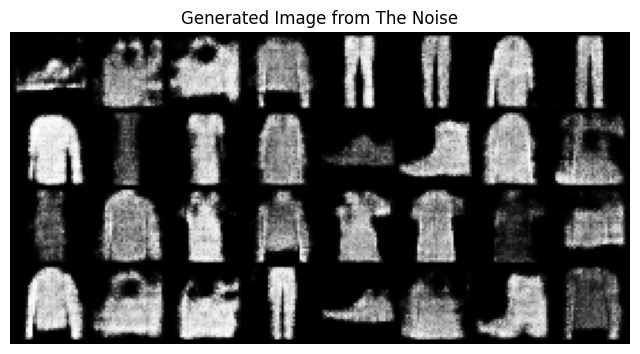

Epoch: 3, Step: 400, D Loss: 1.2714643478393555, G Loss: 0.9761062860488892


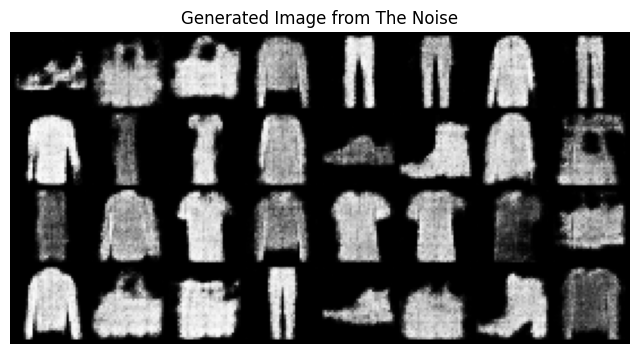

Epoch: 4, Step: 400, D Loss: 1.3916113376617432, G Loss: 0.7827298641204834


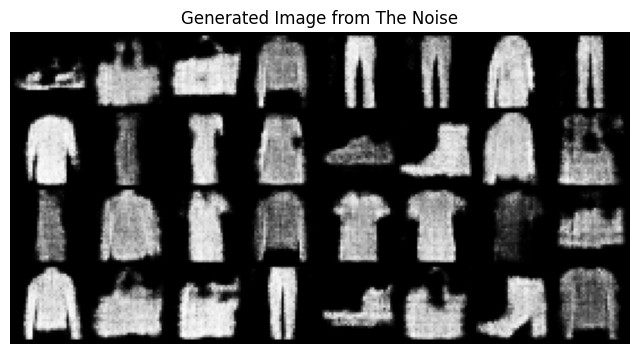

In [5]:
# Comments are just for me to keep the track of the output sizes
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            # Input size = 32x32
            nn.Conv2d(in_channels=1 + num_classes, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size = 16x16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size = 8x8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
            # Output size = 4x4
        )
        self.fc = nn.Sequential(
            nn.Linear(4 * 4 * 256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = self.label_embedding(labels).view(labels.size(0), -1, 1, 1)
        labels = labels.expand(labels.size(0), labels.size(1), x.size(2), x.size(3))
        x = torch.cat((x, labels), dim=1)
        x = self.model(x)
        x = x.view(-1, 4 * 4 * 256)
        x = self.fc(x)
        return x


class Generator(nn.Module):
    def __init__(self, num_classes):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            # Input size = 1x1
            nn.ConvTranspose2d(in_channels=100 + num_classes, out_channels=256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Output size = 4x4
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Output size = 8x8
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Output size = 16x16
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # Output size = 32x32
        )

    def forward(self, x, labels):
        labels = self.label_embedding(labels).view(labels.size(0), -1, 1, 1)
        x = torch.cat((x, labels), dim=1)
        return self.model(x)


def noise(size, num_classes):
    n = torch.randn(size, 100, 1, 1)
    labels = torch.randint(0, num_classes, (size,))
    return n.to(device), labels.to(device)


num_classes = 10 
discriminator = Discriminator(num_classes).to(device)
generator = Generator(num_classes).to(device)

lr = 0.0001
epochs = 5
loss_function = nn.BCELoss()

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

g_losses = []
d_losses = []
d_real_accuracy = []
d_fake_accuracy = []

the_noise, the_labels = noise(32, num_classes)
for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        real_images, real_labels = data
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)
        real_targets = torch.ones(real_images.size(0)).to(device)

        d_optimizer.zero_grad()

        real_outputs = discriminator(real_images, real_labels).view(-1)
        d_real_loss = loss_function(real_outputs, real_targets)
        real_accuracy = (real_outputs > 0.5).float().mean()
        d_real_accuracy.append(real_accuracy.item())

        fake_noise, fake_labels = noise(real_images.size(0), num_classes)
        fake_images = generator(fake_noise, fake_labels).detach()
        fake_targets = torch.zeros(fake_images.size(0)).to(device)
        fake_outputs = discriminator(fake_images, fake_labels).view(-1)
        d_fake_loss = loss_function(fake_outputs, fake_targets)
        fake_accuracy = (fake_outputs < 0.5).float().mean()
        d_fake_accuracy.append(fake_accuracy.item())

        d_loss = d_real_loss + d_fake_loss
        d_losses.append(d_loss.item())
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()
        fake_noise, fake_labels = noise(real_images.size(0), num_classes)
        fake_images = generator(fake_noise, fake_labels)
        outputs = discriminator(fake_images, fake_labels).view(-1)
        g_loss = loss_function(outputs, real_targets)
        g_losses.append(g_loss.item())
        g_loss.backward()
        g_optimizer.step()

        if i % 400 == 0 and i != 0:
            print(f"Epoch: {epoch}, Step: {i}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
            the_noise_image = generator(the_noise, the_labels).cpu()
            the_noise_image = the_noise_image.detach()
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title("Generated Image from The Noise")
            plt.imshow(np.transpose(utils.make_grid(the_noise_image, padding=2, normalize=True), (1, 2, 0)))
            plt.show()

        if (epoch + 1) % 10 == 0 and i % 400 == 0:
            noise_image, noise_labels = noise(32, num_classes)
            noise_image = generator(noise_image, noise_labels).cpu()
            noise_image = noise_image.detach()
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title("Generated Image from Noise for the Final Model")
            plt.imshow(np.transpose(utils.make_grid(noise_image, padding=2, normalize=True), (1, 2, 0)))
            plt.show()


Text(0.5, 0, 'iterations')

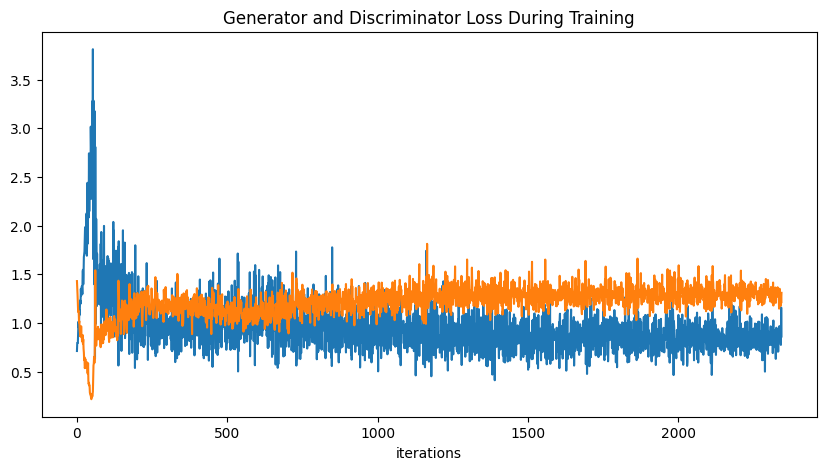

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")

plt.xlabel("iterations")



Text(0.5, 0, 'iterations')

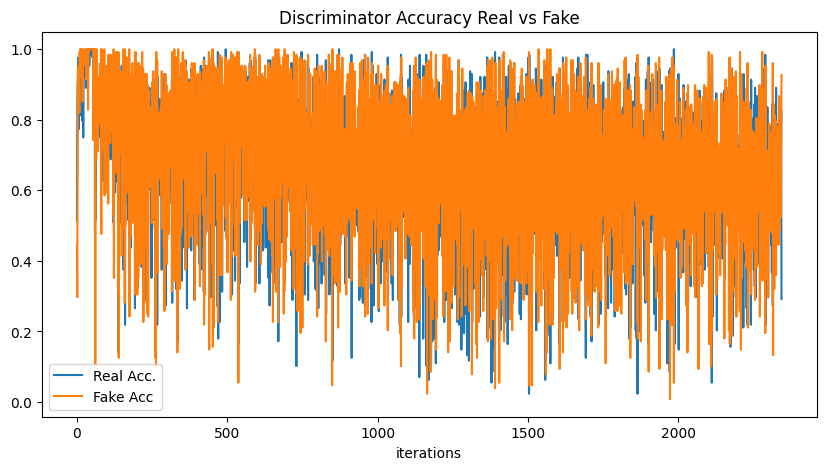

In [7]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Accuracy Real vs Fake")
plt.plot(d_real_accuracy,label="Real Acc.")
plt.plot(d_fake_accuracy,label="Fake Acc")
plt.legend()

plt.xlabel("iterations")

In [8]:
class somehow_VGG(nn.Module):
    def __init__(self):
        super(somehow_VGG, self).__init__()  # Fixed super call
        self.conv_blocks = nn.Sequential(
            # In spatial dim 32x32
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Out spatial dim 16x16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Out spatial dim 8x8
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Out spatial dim 4x4 
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(4*4*64, 512),
            nn.ReLU(), 
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
        
somehow_vgg_model = somehow_VGG()
somehow_vgg_model.to(device)
print(somehow_vgg_model)

somehow_VGG(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3):

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(somehow_vgg_model.parameters(), lr=0.001)
num_epochs = 3

for epoch in range(num_epochs):
    somehow_vgg_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = somehow_vgg_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    somehow_vgg_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = somehow_vgg_model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    features = []





Epoch [1/3], Train Loss: 0.6986, Train Accuracy: 73.90%
Epoch [1/3], Test Loss: 0.4237, Test Accuracy: 83.50%
Epoch [2/3], Train Loss: 0.4029, Train Accuracy: 85.08%
Epoch [2/3], Test Loss: 0.3571, Test Accuracy: 86.07%
Epoch [3/3], Train Loss: 0.3446, Train Accuracy: 87.22%
Epoch [3/3], Test Loss: 0.3198, Test Accuracy: 88.08%


In [10]:

import torch.utils


features = []
labels = []

def hook_fn(m, i, o):
    features.append(o.detach())

somehow_vgg_model.fc_layer[-2].register_forward_hook(hook_fn)

subset_indices_train = np.random.choice(len(train_data), 500, replace=False)
train_data_subset = torch.utils.data.Subset(train_data, subset_indices_train)
train_loader_subset = DataLoader(train_data_subset, batch_size=128, shuffle=False)

subset_indices_test = np.random.choice(len(test_data), 500, replace=False)
test_data_subset = torch.utils.data.Subset(test_data, subset_indices_test)
test_loader_subset = DataLoader(test_data_subset, batch_size=128, shuffle=False)

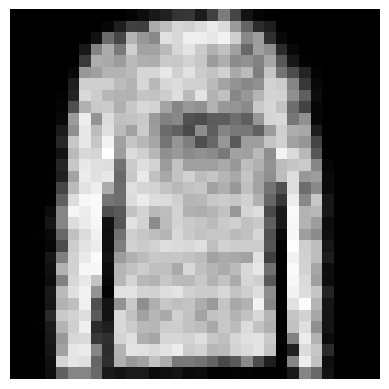

In [11]:
noise = torch.randn(1, 100, 1, 1).to(device)
label = torch.tensor([2]).to(device)

generator.eval()
with torch.no_grad():
    generated_image = generator(noise, label)

generated_image = generated_image.squeeze().cpu().numpy()

plt.imshow(generated_image, cmap='gray')
plt.axis('off')
plt.show()

In [12]:
random_labels = torch.randint(0, 10, (500,)).to(device)
noise = torch.randn(500, 100, 1, 1).to(device)

generator.eval()
with torch.no_grad():
    generated_images = generator(noise, random_labels)

generated_data = torch.utils.data.TensorDataset(generated_images, random_labels)
generated_images_loader = DataLoader(generated_data, batch_size=128, shuffle=False)

In [13]:
for images, labels in train_loader_subset:
    images, labels = images.to(device), labels.to(device)
    _ = somehow_vgg_model(images)
train_loader_subset_features = torch.cat(features).cpu().detach().numpy()
features.clear()

In [14]:

for images, labels in test_loader_subset:
    images, labels = images.to(device), labels.to(device)
    _ = somehow_vgg_model(images)
test_loader_subset_features = torch.cat(features).cpu().detach().numpy()
features.clear()

In [15]:
for images, labels in generated_images_loader:
    images = images.to(device)
    _ = somehow_vgg_model(images)

generated_features = torch.cat(features).cpu().numpy()
features.clear()

In [16]:
print(train_loader_subset_features.shape, test_loader_subset_features.shape, generated_features.shape)

(500, 512) (500, 512) (500, 512)


In [17]:
from sklearn.manifold import TSNE
all_features = np.vstack([train_loader_subset_features, test_loader_subset_features, generated_features])
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

In [18]:
train_embedded = embedded_features[:500]
test_embedded = embedded_features[500:1000]
generated_embedded = embedded_features[1000:]

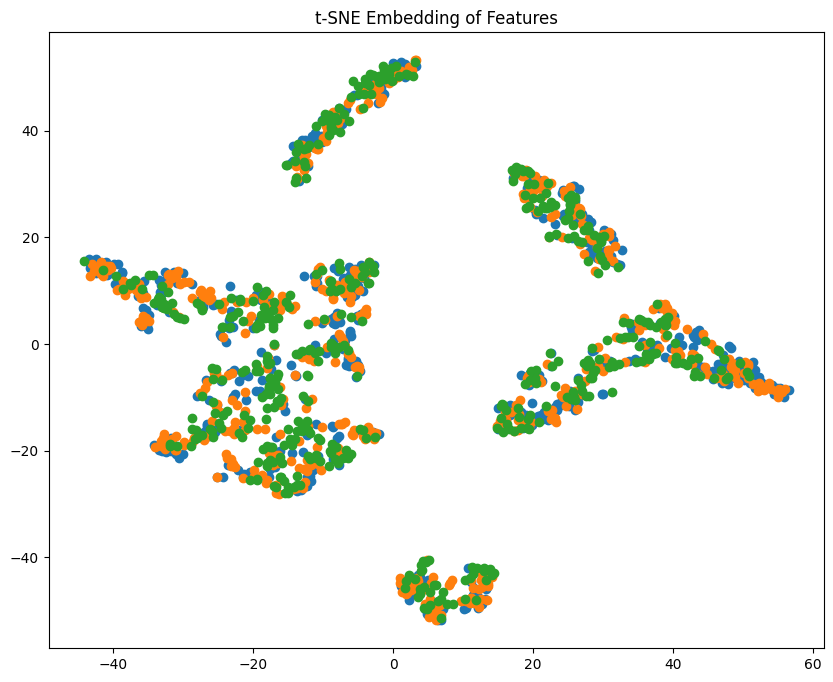

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(train_embedded[:, 0], train_embedded[:, 1])
plt.scatter(test_embedded[:, 0], test_embedded[:, 1])
plt.scatter(generated_embedded[:, 0], generated_embedded[:, 1])
plt.title('t-SNE Embedding of Features')
plt.show()

In [20]:
somehow_vgg_model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for i, data in enumerate(generated_images_loader):
        images = data[0].to(device)
        labels = data[1].to(device)
        
        outputs = somehow_vgg_model(images)
        _, predicted = torch.max(outputs, 1)
        
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        labels = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()
        
        batch_accuracy = np.mean(labels == predicted)
        print(f'Accuracy in Batch {i}: {batch_accuracy:.2f}')

overall_accuracy = total_correct / total_samples
print(f'Overall Accuracy: {overall_accuracy:.2f}')


Accuracy in Batch 0: 0.85
Accuracy in Batch 1: 0.77
Accuracy in Batch 2: 0.89
Accuracy in Batch 3: 0.83
Overall Accuracy: 0.83
